In [2]:
import collections
import itertools
import json

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

import more_itertools
import numpy as np
import redis
import seaborn as sns
import tqdm

# Store patent data in Redis

In [3]:
r_patent_to_codes = redis.Redis(host="127.0.0.1", port=6379, db=0, decode_responses=True)
r_dates_to_patents = redis.Redis(host="127.0.0.1", port=6379, db=1, decode_responses=True)

In [3]:
def store_patent_data_in_redis(r_patent_to_codes, r_dates_to_patents):
    """
    #0000003 - 473119000 - X - 18360811
    #0000004 - 142010000 - O - 18360810

    #0435748 - 132215000
    """
    rp_patent_to_codes = r_patent_to_codes.pipeline()
    rp_dates_to_patents = r_dates_to_patents.pipeline()
    line_cnt = 0
    with open("data/mcfpat1402-with_issue_date.txt") as handle:
        for chunk in tqdm.tqdm(more_itertools.chunked(handle, 10_000)):
            for line in chunk:
                line_cnt += 1
                patent_number = line[:7]
                classification = line[7:10]

                subclassification = line[10:16]
                classification_type_code = line[16]
                issue_date = line[17:25]

                rp_patent_to_codes.sadd(patent_number, classification + subclassification)
                rp_dates_to_patents.sadd(issue_date, patent_number)

            rp_patent_to_codes.execute()
            rp_dates_to_patents.execute()        
    print(f"Lines added: {line_cnt}")

In [6]:
# store_patent_data_in_redis(r_patent_to_codes, r_dates_to_patents)

3211it [21:33,  2.48it/s]

Lines added: 32101924


In [4]:
patent_numbers = sorted(r_patent_to_codes.keys())
issue_dates = sorted(r_dates_to_patents.keys())

# calculate the code per patent distro
# code_counts = []
# for pn in tqdm.tqdm(patent_numbers):
#     code_counts.append(len(r_patent_to_codes.smembers(pn)))

import json
with open("results/patent_code_counts.json") as handle:
    code_counts = json.load(handle)

In [19]:
issue_dates

['00000000',
 '17000101',
 '17900731',
 '17910129',
 '17911230',
 '17921020',
 '17930129',
 '17940314',
 '17950116',
 '17950325',
 '17960415',
 '17960420',
 '17970605',
 '17970626',
 '17970628',
 '17980108',
 '17980322',
 '17981214',
 '17990214',
 '17990319',
 '17990424',
 '17990430',
 '18000101',
 '18001117',
 '18010220',
 '18010316',
 '18020401',
 '18020715',
 '18020921',
 '18030211',
 '18030214',
 '18030513',
 '18040430',
 '18040510',
 '18040929',
 '18041029',
 '18050510',
 '18050521',
 '18051217',
 '18060205',
 '18060308',
 '18060331',
 '18060401',
 '18060525',
 '18070212',
 '18070225',
 '18070505',
 '18070508',
 '18070608',
 '18070724',
 '18071104',
 '18071120',
 '18071213',
 '18071215',
 '18080319',
 '18080423',
 '18080429',
 '18080521',
 '18080603',
 '18080709',
 '18080711',
 '18080713',
 '18080802',
 '18080816',
 '18080825',
 '18081005',
 '18081019',
 '18081028',
 '18081121',
 '18081125',
 '18081210',
 '18090106',
 '18090107',
 '18090116',
 '18090215',
 '18090322',
 '18090426',

In [6]:
import json
# with open("patent_novelties.json", 'w') as handle:
#     json.dump({
#         "novelty_count": novelty_count,
#         "novelty_pair_count": novelty_pair_count,
#     }, handle)
with open("results/patent_novelties.json") as handle:
    temp = json.load(handle)
    novelty_count = temp["novelty_count"]
    novelty_pair_count = temp["novelty_pair_count"]

Fit performed; alpha=0.32524892221604873 c=990.3244950607711
NEW FIT
376222 376222
Fit performed; alpha=0.5963101110529982 c=34.77091922874471


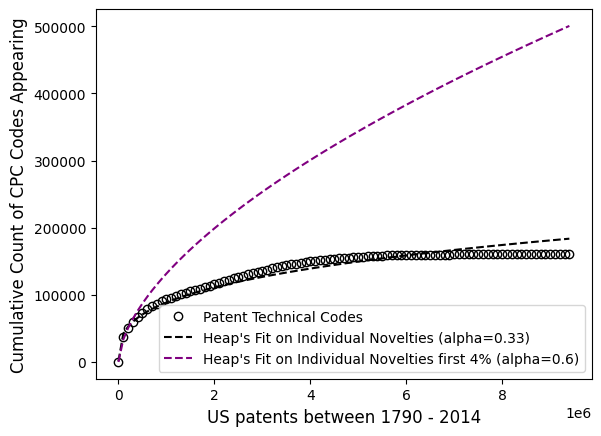

In [31]:
STEP_SIZE = 100_000
#sns.set_theme(style="whitegrid")
plt.plot(
    range(0, len(novelty_count), STEP_SIZE),
    novelty_count[::STEP_SIZE],
    "o", color="black", markerfacecolor='none',
    label="Patent Technical Codes",
)

# plt.plot(
#     range(0, len(novelty_pair_count), STEP_SIZE),
#     novelty_pair_count[::STEP_SIZE],
#     "^", color="blue", markerfacecolor='none',
#     label="Codes",
# )

###########################
from sklearn.linear_model import LinearRegression
libs_count = novelty_count
xs = np.array(range(1, len(libs_count)+1))
xs_transformed = np.log(xs).reshape(-1 ,1 )
counts_transformed = np.log(np.array(libs_count) + 1)

model = LinearRegression()
model.fit(xs_transformed, counts_transformed)

alpha = model.coef_[0]
log_c = model.intercept_
c = np.exp(log_c)
print(f"Fit performed; alpha={alpha} c={c}")
############################

plt.plot(xs[::STEP_SIZE], [c * x ** alpha for x in xs[::STEP_SIZE]], "k--", label=f"Heap's Fit on Individual Novelties (alpha={round(alpha, 2)})")
#plt.plot(xs[::STEP_SIZE], [(c * x ** alpha) * (c * x ** alpha - 1) / 2 for x in xs[::STEP_SIZE]], "g--", label=f"Heap's Theoretical Upper bound on comb. novelties")

###########################
INITIAL_SEGMENT = 25

from sklearn.linear_model import LinearRegression
libs_count = novelty_count
partial_xs = np.array(range(1, len(libs_count) // INITIAL_SEGMENT  + 1))
partial_xs_transformed = np.log(partial_xs).reshape(-1 ,1 )
counts_transformed = np.log(np.array(libs_count[:len(libs_count) // INITIAL_SEGMENT ]) + 1)
print("NEW FIT")
model = LinearRegression()
print(len(partial_xs_transformed), len(counts_transformed))
model.fit(partial_xs_transformed, counts_transformed)

alpha = model.coef_[0]
log_c = model.intercept_
c = np.exp(log_c)
print(f"Fit performed; alpha={alpha} c={c}")
############################
plt.plot(xs[::STEP_SIZE], [c * x ** alpha for x in xs[::STEP_SIZE]], "--", color="purple", label=f"Heap's Fit on Individual Novelties first {round(1/INITIAL_SEGMENT * 100)}% (alpha={round(alpha, 2)})")


plt.xlabel("US patents between 1790 - 2014", fontsize=12)
plt.ylabel("Cumulative Count of CPC Codes Appearing", fontsize=12)

def format_with_commas(x):
    return '{:,}'.format(int(x))

# # Add grid
#plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.5)
plt.legend()
#plt.loglog()

In [130]:
def format_with_commas(x):
    return '{:,}'.format(int(x))

[format_with_commas(x) for x in list(range(0, 10_000_000, 2_000_000))]

['0', '2,000,000', '4,000,000', '6,000,000', '8,000,000']

Text(0.5, 1.0, 'Pair novelties in Patents (linear scale)')

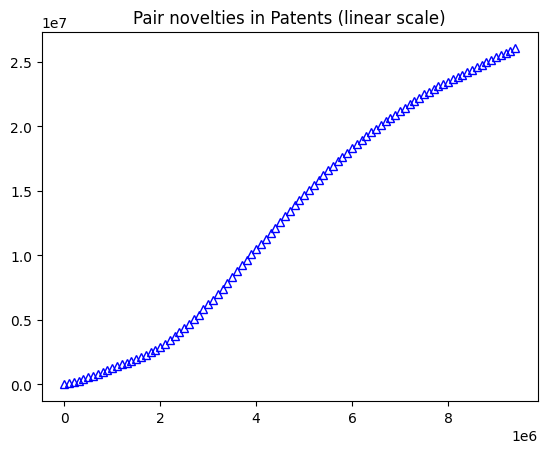

In [16]:
STEP_SIZE = 100_000

plt.plot(
    range(0, len(novelty_pair_count), STEP_SIZE),
    novelty_pair_count[::STEP_SIZE],
    "^", color="blue", markerfacecolor='none',
    label="Codes",
)
plt.title("Pair novelties in Patents (linear scale)")

Text(0.5, 1.0, 'Combinatorial Growth (2-element-combinations)')

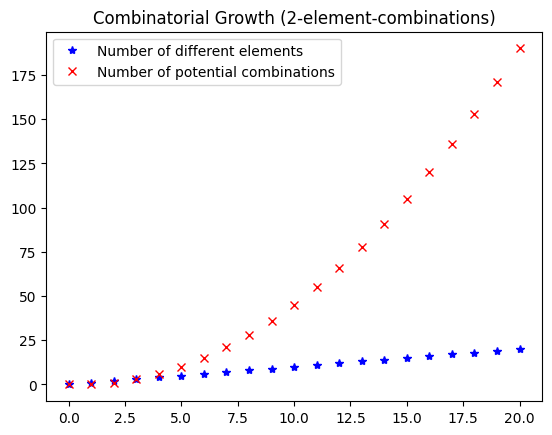

In [22]:

nums = list(range(21))
plt.plot(nums, nums, "b*", label="Number of different elements")
plt.plot([n * (n-1) / 2 for n in nums], "rx", label="Number of potential combinations")
plt.legend()
plt.title("Combinatorial Growth (2-element-combinations)")

Text(0.5, 1.0, 'Sublinear Combinatorial Growth (2-element-combinations)')

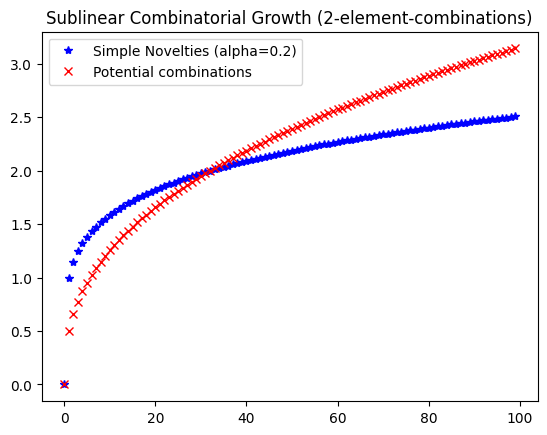

In [65]:
nums = list(range(100))
c,  alpha = 1.0, 0.2
plt.plot(nums, [c* x**alpha for x in nums], "b*", label=f"Simple Novelties (alpha={alpha})")
plt.plot([c/2*x**(2*alpha) for x in nums], "rx", label="Potential combinations")
plt.legend()
plt.title("Sublinear Combinatorial Growth (2-element-combinations)")

Generate the fake data alongside with the true patents:

Text(0.5, 1.0, 'Novelties in Patents')

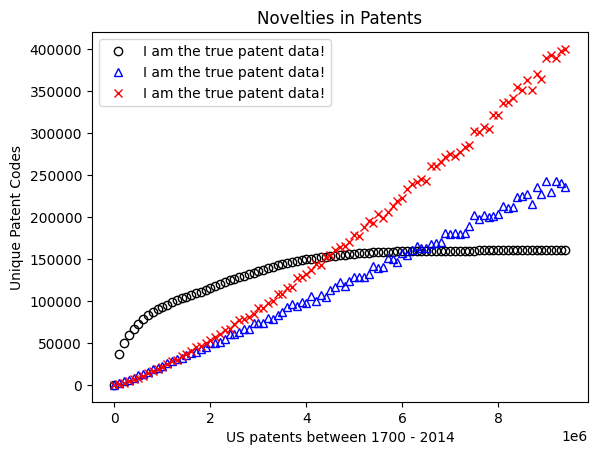

In [63]:
import random

STEP_SIZE = 100_000

xs = list(range(0, len(novelty_count), STEP_SIZE))
plt.plot(
    xs,
    novelty_count[::STEP_SIZE],
    "o", color="black", markerfacecolor='none',
    label="I am the true patent data!",
)
plt.plot(
    xs,
    [x**1.05 * (1 + random.random() / 10) / 90     for x in xs],
    "^", color="blue", markerfacecolor='none',
    label="I am the true patent data!",
)
plt.plot(
    xs,
    [x**1.3 * (1 + random.random() / 15) / 3000     for x in xs],
    "x", color="red", markerfacecolor='none',
    label="I am the true patent data!",
)
plt.xlabel("US patents between 1700 - 2014")
plt.ylabel("Unique Patent Codes")
plt.legend()
plt.title("Novelties in Patents")

In [27]:
issue_dates[1], issue_dates[-1]

('17000101', '20140225')

In [72]:
r_dates_to_patents.smembers(issue_dates[1])
r_patent_to_codes.smembers('X004871')

{'122178000'}

In [6]:
cc = collections.Counter(code_counts)

[]

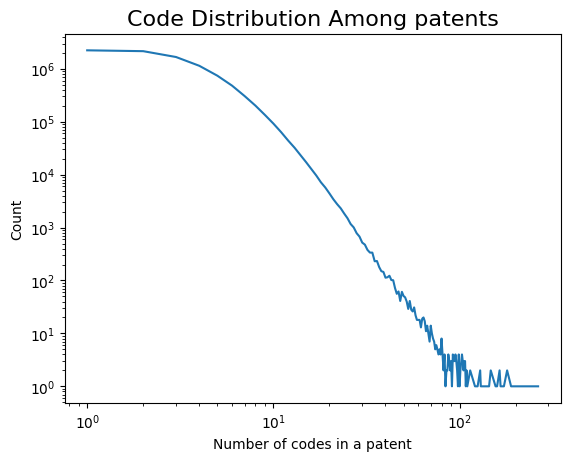

In [12]:
plt.plot(sorted(cc.keys()), [cc[k] for k in sorted(cc.keys())])
plt.title("Code Distribution Among patents", fontsize=16)
plt.xlabel("Number of codes in a patent")
plt.ylabel("Count")
plt.loglog()

# Pair overshots

In [28]:
import os
import pathlib

my_path = "results/sims/"

os.listdir(pathlib.Path(my_path))

['patent_sim_rounds_100000_bps_1000000_nei_1000_noi_900.json',
 'patent_sim_rounds_10_bps_100_nei_5_noi_10.json',
 'patent_sim_rounds_250000_bps_50000_nei_10_noi_5.json',
 'patent_sim_rounds_250000_bps_25000_nei_10_noi_4.json',
 'patent_sim_rounds_1000_bps_100000_nei_500_noi_100.json',
 'patent_sim_rounds_100000_bps_20000_nei_10_noi_8.json',
 'patent_sim_rounds_1000000_bps_10000000_nei_1000_noi_900.json',
 'patent_sim_rounds_250000_bps_22000_nei_10_noi_8.json']

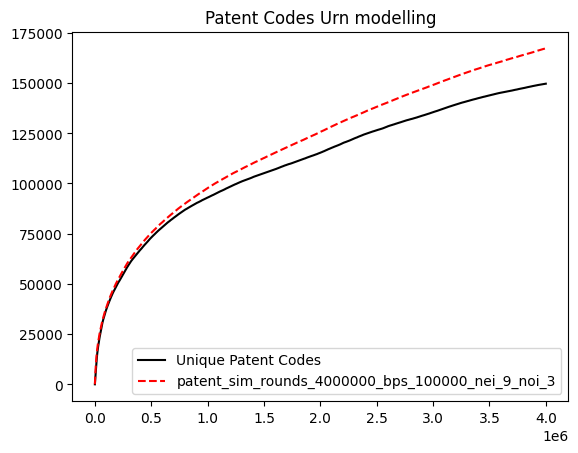

In [58]:
sim_file = "patent_sim_rounds_4000000_bps_100000_nei_9_noi_3.json"
with open(f"results/sims/{sim_file}") as handle:
    sim = json.load(handle)

STEP_SIZE = 100
xs = list(range(min(len(novelty_count), len(sim.get("element_counts")))))

plt.plot(xs[::STEP_SIZE], novelty_count[:len(xs):STEP_SIZE],"-", color="black", markerfacecolor='none', label="Unique Patent Codes")
plt.plot(xs[::STEP_SIZE], sim.get("element_counts")[::STEP_SIZE], "--", color='red', label=sim_file.split(".")[0])
#plt.loglog()
plt.title("Patent Codes Urn modelling")
plt.legend()

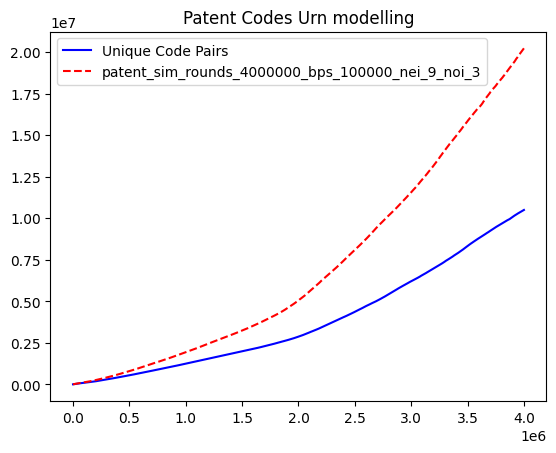

In [57]:
sim_file = "patent_sim_rounds_4000000_bps_100000_nei_9_noi_3.json"
with open(f"results/sims/{sim_file}") as handle:
    sim = json.load(handle)

STEP_SIZE = 100
xs = list(range(min(len(novelty_count), len(sim.get("pairs_counts")))))

plt.plot(xs[::STEP_SIZE], novelty_pair_count[:len(xs):STEP_SIZE],"-", color="blue", markerfacecolor='none', label="Unique Code Pairs")
plt.plot(xs[::STEP_SIZE], sim.get("pairs_counts")[::STEP_SIZE], "--", color='red', label=sim_file.split(".")[0])
plt.title("Patent Codes Urn modelling")
#plt.loglog()
plt.legend()

# Heap's Fit

Fit took 1.76 seconds
Fit performed; alpha=0.32524892221604873 c=990.3244950607711


Text(0.5, 1.0, 'US Patent Novelties')

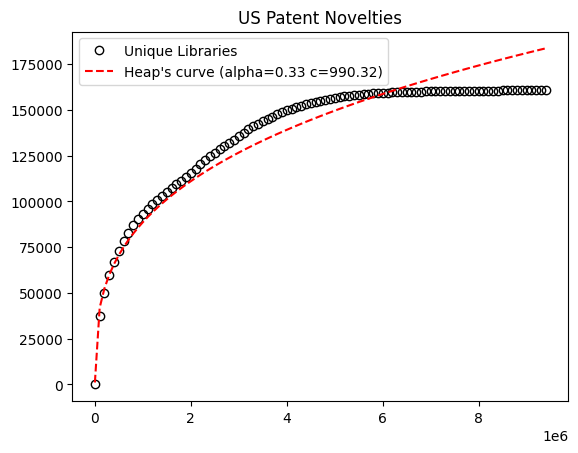

In [54]:
###########################
from sklearn.linear_model import LinearRegression
import time

t0 = time.time()
libs_count = novelty_count
xs = np.array(range(1, len(libs_count)+1))
xs_transformed = np.log(xs).reshape(-1 ,1 )
counts_transformed = np.log(np.array(libs_count) + 1)

model = LinearRegression()
model.fit(xs_transformed, counts_transformed)

alpha = model.coef_[0]
log_c = model.intercept_
c = np.exp(log_c)
t1 = time.time()

print(f"Fit took {round(t1-t0, 2)} seconds")
print(f"Fit performed; alpha={alpha} c={c}")
############################
STEP_SIZE = 100000
plt.plot(xs[::STEP_SIZE], libs_count[::STEP_SIZE], "o", color="black", markerfacecolor='none', label="Unique Libraries")
plt.plot(xs[::STEP_SIZE], [c*x**alpha for x in xs[::STEP_SIZE]], "--", color="red", label=f"Heap's curve (alpha={round(alpha, 2)} c={round(c, 2)})")
plt.legend()
plt.title("US Patent Novelties")


In [47]:
len(novelty_count), len(novelty_pair_count)

(9405571, 9405571)

(0.0, 1000.0)

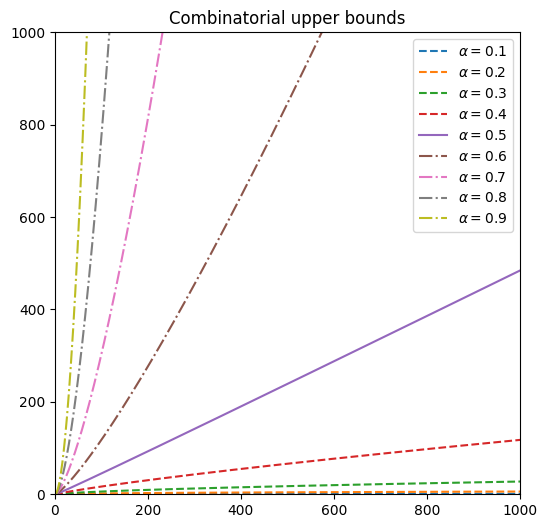

In [63]:
plt.figure(figsize=(6, 6))
xs = list(range(10_000))

for alpha in np.arange(0.1, 1.0, 0.1):
    pattern = "-" if round(alpha, 1) == 0.5 else "-." if alpha > 0.5 else "--"
    ys = [x ** alpha for x in xs]
    #plt.plot(xs, ys, label=f"alpha={alpha}")
    plt.plot(xs, [x * (x-1) / 2 for x in ys], pattern, label=f"$\\alpha={round(alpha, 1)}$")
plt.legend(loc="upper right")
plt.title("Combinatorial upper bounds")
plt.ylim(0, 1000)
plt.xlim(0, 1000)

In [71]:
patent_numbers[3]

'0000004'

# Find the mustache guard

In [21]:
codes = set()
with open("data/mcfpat1402-with_issue_date.txt") as handle:
        for line in tqdm.tqdm(handle):
            patent_number = line[:7]
            classification = line[7:10]

            subclassification = line[10:16]
            classification_type_code = line[16]
            issue_date = line[17:25]
            if int(issue_date[:4]) > 1891:
                continue
            codes.add(classification + subclassification)


0it [00:00, ?it/s]
51955it [00:00, 519528.20it/s]
132751it [00:00, 689180.79it/s]
215790it [00:00, 753650.06it/s]
298939it [00:00, 784372.03it/s]
381782it [00:00, 800252.77it/s]
465472it [00:00, 812705.66it/s]
549148it [00:00, 820564.59it/s]
632210it [00:00, 823755.95it/s]
715638it [00:00, 827041.80it/s]
799078it [00:01, 829306.92it/s]
886071it [00:01, 841734.80it/s]
982410it [00:01, 878728.63it/s]
1079022it [00:01, 905196.98it/s]
1177795it [00:01, 930119.05it/s]
1275100it [00:01, 943053.71it/s]
1372841it [00:01, 953389.58it/s]
1470871it [00:01, 961475.48it/s]
1568125it [00:01, 964793.56it/s]
1665564it [00:01, 967670.47it/s]
1763265it [00:02, 970469.94it/s]
1861380it [00:02, 973669.71it/s]
1958747it [00:02, 973300.97it/s]
2056425it [00:02, 974339.38it/s]
2153859it [00:02, 973685.90it/s]
2251228it [00:02, 913913.58it/s]
2343366it [00:02, 873863.35it/s]
2436509it [00:02, 890031.53it/s]
2528907it [00:02, 899748.39it/s]
2622851it [00:02, 911265.12it/s]
2717426it [00:03, 921369.65it/s]
281

In [23]:
codes

{'194255000',
 'D11202000',
 '23508500R',
 '084131000',
 '361104000',
 '408027000',
 '049185000',
 '220585000',
 '427122000',
 '336075000',
 '239685000',
 '606232000',
 '432004000',
 '384545000',
 '040403000',
 '119055000',
 '124017000',
 '213019000',
 '210501000',
 '301095108',
 '034606000',
 '048170000',
 '293003000',
 '019241000',
 '473565000',
 '280086100',
 '118116000',
 '279002190',
 '280015000',
 '071064070',
 '451358000',
 '426493000',
 '423317000',
 '300001000',
 '454345000',
 '139147000',
 '254353000',
 '366097000',
 '462025000',
 '073584000',
 '211089010',
 '430357000',
 '123188400',
 '494013000',
 '277522000',
 '493196000',
 '114174000',
 '414555000',
 '220541000',
 '360135000',
 '038085000',
 'D06709110',
 '1230800DA',
 '310090000',
 '052151000',
 '024192000',
 '200285000',
 '074547000',
 '091165000',
 '428933000',
 '165DIG084',
 '092068000',
 '248514000',
 '122022000',
 '02403050S',
 '072393000',
 '420569000',
 '122197000',
 'D08324000',
 '546153000',
 '165041000',
 '9681

In [24]:
"132215000" in codes

True

Fit performed; alpha=0.32524892221604873 c=990.3244950607711
NEW FIT
376222 376222
Fit performed; alpha=0.5963101110529982 c=34.77091922874471


[]

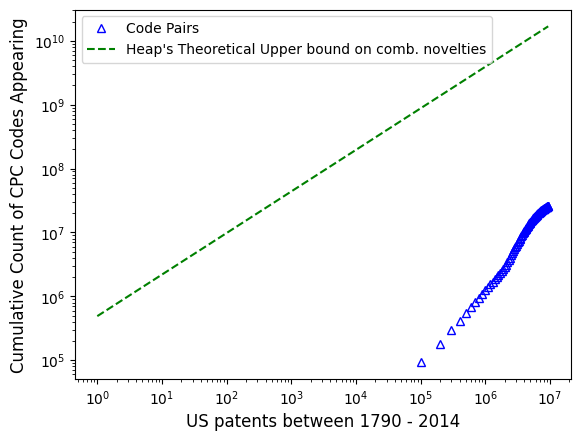

In [30]:
STEP_SIZE = 100_000
#sns.set_theme(style="whitegrid")
# plt.plot(
#     range(0, len(novelty_count), STEP_SIZE),
#     novelty_count[::STEP_SIZE],
#     "o", color="black", markerfacecolor='none',
#     label="Patent Technical Codes",
# )

plt.plot(
    range(0, len(novelty_pair_count), STEP_SIZE),
    novelty_pair_count[::STEP_SIZE],
    "^", color="blue", markerfacecolor='none',
    label="Code Pairs",
)

###########################
from sklearn.linear_model import LinearRegression
libs_count = novelty_count
xs = np.array(range(1, len(libs_count)+1))
xs_transformed = np.log(xs).reshape(-1 ,1 )
counts_transformed = np.log(np.array(libs_count) + 1)

model = LinearRegression()
model.fit(xs_transformed, counts_transformed)

alpha = model.coef_[0]
log_c = model.intercept_
c = np.exp(log_c)
print(f"Fit performed; alpha={alpha} c={c}")
############################

#plt.plot(xs[::STEP_SIZE], [c * x ** alpha for x in xs[::STEP_SIZE]], "k--", label=f"Heap's Fit on Individual Novelties (alpha={round(alpha, 2)})")
plt.plot(xs[::STEP_SIZE], [(c * x ** alpha) * (c * x ** alpha - 1) / 2 for x in xs[::STEP_SIZE]], "g--", label=f"Heap's Theoretical Upper bound on comb. novelties")

###########################
INITIAL_SEGMENT = 25

from sklearn.linear_model import LinearRegression
libs_count = novelty_count
partial_xs = np.array(range(1, len(libs_count) // INITIAL_SEGMENT  + 1))
partial_xs_transformed = np.log(partial_xs).reshape(-1 ,1 )
counts_transformed = np.log(np.array(libs_count[:len(libs_count) // INITIAL_SEGMENT ]) + 1)
print("NEW FIT")
model = LinearRegression()
print(len(partial_xs_transformed), len(counts_transformed))
model.fit(partial_xs_transformed, counts_transformed)

alpha = model.coef_[0]
log_c = model.intercept_
c = np.exp(log_c)
print(f"Fit performed; alpha={alpha} c={c}")
############################

def binom(x):
    return x * (x-1) / 2

#plt.plot(xs[::STEP_SIZE], [c * x ** alpha for x in xs[::STEP_SIZE]], "--", color="purple", label=f"Heap's Fit on Individual Novelties first {round(1/INITIAL_SEGMENT * 100)}% (alpha={round(alpha, 2)})")
#plt.plot(xs[::STEP_SIZE], [c * x ** alpha for x in xs[::STEP_SIZE]], "--", color="purple", label=f"Heap's Fit on Individual Novelties first {round(1/INITIAL_SEGMENT * 100)}% (alpha={round(alpha, 2)})")


plt.xlabel("US patents between 1790 - 2014", fontsize=12)
plt.ylabel("Cumulative Count of CPC Codes Appearing", fontsize=12)

def format_with_commas(x):
    return '{:,}'.format(int(x))

# # Add grid
#plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.5)
plt.legend()
plt.loglog()